# Notebook analysis trade-off Imagenette


In this notebook we analyzed the tradeoff in CNNs between perspective invariance and adversarial data.

In [11]:
# INSTALL LIBRARY FOR G-CNNS
! pip install numpy scipy matplotlib nose
! pip install chainer
! pip install ipywidgets
%cd /notebooks/
! git clone https://github.com/adambielski/GrouPy.git
%cd /notebooks/GrouPy

! ls
! python3 "/notebooks/GrouPy/setup.py" install

! ls
! ls

! pip install kornia
! pip install torchattacks
! pip install torchsummary 
! pip install netcal

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
/notebooks
fatal: destination path 'GrouPy' already exists and is not an empty directory.
/notebooks/GrouPy
LICENSE    calibration_library	p4_fmaps.png		 requirements.txt
README.md  groupy		p4m_fmaps.png		 setup.py
build	   p4_anim.gif		reliability_diagram.png
running install
running build
running build_py
running install_lib
running install_egg_info
Removing /opt/conda/lib/python3.8/site-packages/GrouPy-0.1.2-py3.8.egg-info
Writing /opt/conda/lib/python3.8/site-packages/GrouPy-0.1.2-py3.8.egg-info
LICENSE    calibration_library	p4_fmaps.png		 requirements.txt
README.md  groupy		p4m_fmaps.png		 setup.py
build	   p4_anim.gif		reliability_diagram.png
LICENSE    calibration_library	p4_fmaps.png		 requirements.txt
README.md  groupy		p4m_fmaps.png		 setup.py
build	   p4_anim.

In [12]:
import torch
import numpy as np
import sklearn
import scipy
import pandas as pd
import torch
import matplotlib.pyplot as plt

import torchvision
from typing import *
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

from torch.nn import functional as F
from torch.nn import Conv2d
from torch.nn import MaxPool2d as MaxPool2d
from tqdm import tqdm
import torchvision.models as models
import torchvision.datasets as datasets 
import torchvision.transforms as transforms


#import the library dedicated to Groups
from groupy.gconv.pytorch_gconv.pooling import plane_group_spatial_max_pooling
from groupy.gconv.pytorch_gconv import P4ConvZ2, P4ConvP4

# Reproducability stuff

In [13]:
#REPRODUCIABILYT STUFF

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

import random
import numpy as np
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

torch.cuda.manual_seed(0)

from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {'limit_output': 5000})

Using device: cuda:0


# Dataset Imagenette

In [14]:
#! wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz

In [15]:
# Unzip raw zip file
#! mkdir imagenette
#! tar -xzvf 'imagenette2-160.tgz' -C '/notebooks/imagenette'

In [16]:
import kornia.augmentation as K

means = (0.4914, 0.4822, 0.4465)

transform_train2 = transforms.Compose([
    
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(150),
    #transforms.RandomPerspective(distortion_scale=0.2),
    transforms.ToTensor(),
    #transforms.Normalize(means, (0.2023, 0.1994, 0.2010)),
])

transform_test2 = transforms.Compose([

    transforms.CenterCrop(150),
    transforms.ToTensor(),
    #transforms.Normalize(means, (0.2023, 0.1994, 0.2010)),
])


trainset_imagenette = torchvision.datasets.ImageFolder("/notebooks/imagenette/imagenette2-160/train", transform=transform_train2)
testset_imagenette = torchvision.datasets.ImageFolder("/notebooks/imagenette/imagenette2-160/val", transform=transform_test2)


train_set_imagenette, val_set_imagenette = torch.utils.data.random_split(trainset_imagenette, [8969,500])


#create the dataloaders
train_loader_imagenette = torch.utils.data.DataLoader(train_set_imagenette, batch_size=64, shuffle=True, num_workers=20)
val_loader_imagenette = torch.utils.data.DataLoader(val_set_imagenette, batch_size=32, shuffle=True, num_workers=20)
test_loader_imagenette = torch.utils.data.DataLoader(testset_imagenette, batch_size=32, shuffle=True, num_workers=20)

print(len(test_loader_imagenette.dataset))

3925


In [ ]:
import kornia.augmentation as K

# PLOT SOME EXMAPLES OF TRANSFORMATIONs

# 1) perspective 2) Gaussian Noise

perspective = K.AugmentationSequential(K.RandomPerspective(distortion_scale=0.6, p=0.8))
gaussian_noise = K.AugmentationSequential(K.RandomGaussianNoise(mean=0, std=0.2, p=1))
motion_blur = K.AugmentationSequential(K.RandomMotionBlur(kernel_size=5, angle=(-180,180), p=1, direction=0.5))

batch = (next(iter(train_loader_imagenette)))[0]

batch_transformed = motion_blur(batch)

i=0
for (inputs) in batch:
    plt.figure()
    img = inputs.permute(1, 2, 0)
    #for p in inputs :
    plt.imshow(img)
    plt.show()

Text(0.5, 1.0, 'Moltion Blur (kernel size = 7)')

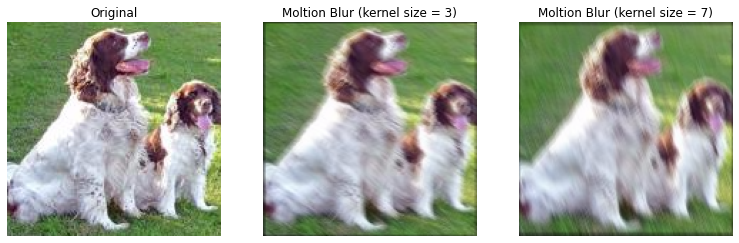

In [8]:
# setting values to rows and column variables
rows = 1
columns = 3
pic = 27

# create figure
fig = plt.figure(figsize=(13, 10))

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
inputs1 = batch[pic].permute(1,2,0)

# showing image
plt.imshow(inputs1)
plt.axis('off')
plt.title("Original")

# Adds a subplot at the 2st position
fig.add_subplot(rows, columns, 2)
inputs2 = batch_transformed[pic].permute(1,2,0)

# showing image
plt.imshow(inputs2)
plt.axis('off')
plt.title("Moltion Blur (kernel size = 3)")


# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
inputs3 = torch.reshape( K.RandomMotionBlur(kernel_size=7, angle=(-180,180), p=1, direction=0.5)(batch[pic]), (3,150,150)).permute(1,2,0)

# showing image
plt.imshow(inputs3)
plt.axis('off')
plt.title("Moltion Blur (kernel size = 7)")

# Model

In [17]:
class Normalize(nn.Module):
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        # Broadcasting
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std

In [18]:
"""ResNet in PyTorch.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import time

from torch.autograd import Variable


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, use_batchnorm=True):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        if not use_batchnorm:
            self.bn1 = self.bn2 = nn.Sequential()

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(self.expansion * planes) if use_batchnorm else nn.Sequential(),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, use_batchnorm=True):
        super(Bottleneck, self).__init__()

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        if not use_batchnorm:
            self.bn1 = self.bn2 = self.bn3 = nn.Sequential()

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(self.expansion * planes) if use_batchnorm else nn.Sequential(),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, 
                 use_batchnorm=True):
        super(ResNet, self).__init__()

        self.in_planes = 64
        self.use_batchnorm = use_batchnorm
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64) if use_batchnorm else nn.Sequential()
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(2048 * block.expansion, num_classes)
   
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, self.use_batchnorm))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        #print(out.shape)
        out = self.layer1(out)
        #print(out.shape)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)

        return out


def ResNet10(num_classes=10, use_batchnorm=True):
    return ResNet(BasicBlock, [1, 1, 1, 1], num_classes=num_classes, use_batchnorm=use_batchnorm)

def ResNet18(num_classes=10, use_batchnorm=True):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes, use_batchnorm=use_batchnorm)

def ResNet34(num_classes=10, use_batchnorm=True):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes, use_batchnorm=use_batchnorm)

def ResNet50(num_classes=10, use_batchnorm=True):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes, use_batchnorm=use_batchnorm)

def ResNet101(num_classes=10, use_batchnorm=True):
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes=num_classes, use_batchnorm=use_batchnorm)

def ResNet152(num_classes=10, use_batchnorm=True):
    return ResNet(Bottleneck, [3, 8, 36, 3], num_classes=num_classes, use_batchnorm=use_batchnorm)

#utility function to count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def test():
    
    from torchsummary import summary
    net = ResNet10(10,True)
    net.cuda()
    summary(net, (3, 150, 150))
    y = net(Variable(torch.randn(1, 3, 150, 150)).cuda())
    print(y.size())


test()



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 75, 75]           1,728
       BatchNorm2d-2           [-1, 64, 75, 75]             128
            Conv2d-3           [-1, 64, 75, 75]          36,864
       BatchNorm2d-4           [-1, 64, 75, 75]             128
            Conv2d-5           [-1, 64, 75, 75]          36,864
       BatchNorm2d-6           [-1, 64, 75, 75]             128
        BasicBlock-7           [-1, 64, 75, 75]               0
            Conv2d-8          [-1, 128, 38, 38]          73,728
       BatchNorm2d-9          [-1, 128, 38, 38]             256
           Conv2d-10          [-1, 128, 38, 38]         147,456
      BatchNorm2d-11          [-1, 128, 38, 38]             256
           Conv2d-12          [-1, 128, 38, 38]           8,192
      BatchNorm2d-13          [-1, 128, 38, 38]             256
       BasicBlock-14          [-1, 128,

In [19]:
'''ResNet with Group-Convolution in PyTorch.'''


from torch.autograd import Variable
from groupy.gconv.pytorch_gconv import P4MConvZ2, P4MConvP4M
from torch.nn import functional as F


# Costruisco i blocchi per Resnet come prima solo che al loro interno invece dei layer di convoluzione standard utilizzo la Group-Convolution (P4MConvZ2, P4MConvP4M)
class BasicBlock_Group(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock_Group, self).__init__()
        self.conv1 = P4MConvP4M(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(planes)
        self.conv2 = P4MConvP4M(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                P4MConvP4M(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class Bottleneck_Group(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck_Group, self).__init__()
        self.conv1 = P4MConvP4M(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = P4MConvP4M(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = P4MConvP4M(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                P4MConvP4M(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class P4mResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(P4mResNet, self).__init__()

        self.in_planes = 23

        self.conv1 = P4MConvZ2(3, 23, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(23)
        self.layer1 = self._make_layer(block, 23, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 45, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 91, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 181, num_blocks[3], stride=2)
        self.linear = nn.Linear(23168 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        #print(x.shape)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        outs = out.size()
        out = out.view(outs[0], outs[1]*outs[2], outs[3], outs[4])
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        #print(out.shape)
        return out

def P4mResNet10(num_class):
    return P4mResNet(BasicBlock_Group, [1,1,1,1], num_classes=num_class)

def P4mResNet18(num_class):
    return P4mResNet(BasicBlock_Group, [2,2,2,2], num_classes=num_class)

def P4mResNet34():
    return P4mResNet(BasicBlock_Group, [3,4,6,3])

def P4mResNet50():
    return P4mResNet(Bottleneck_Group, [3,4,6,3])

def P4mResNet101():
    return P4mResNet(Bottleneck_Group, [3,4,23,3])

def P4mResNet152():
    return P4mResNet(Bottleneck_Group, [3,8,36,3])

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def test():
    net = P4mResNet10(10)
    print("params : " , count_parameters(net))
    y = net(Variable(torch.randn(1,3,150,150)))
    print(y.size())

test()

params :  5139431
torch.Size([1, 10])


# Utility functions

In [20]:
from tqdm import tqdm


best_acc = 0  # best test accuracy


# Clean Training
def train(epoch, loader , net, optimizer, loss_func, log_freq):

    net.train()
    running_loss=0
    correct = 0
    total = 0
    losses = []

    for batch_idx, (inputs, targets) in enumerate(tqdm(loader)):
        
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)

        loss = loss_func(outputs, targets)

        running_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum().item()
        
        # print statistics every log_freq mini batch
        if (batch_idx+1) % log_freq == 0:    # print every log_freq mini batches
            print('[Epoch : %d, Iter: %5d] loss: %.3f' %
                  (epoch + 1, batch_idx, running_loss / log_freq))
            losses.append( running_loss / log_freq)
            running_loss = 0.0
            print('Top1 Accuracy of the network on the trainset images:', correct / total)
            correct=0
            total=0
        
    return losses



# validation clean images
def validation(i, net, loader, loss_func, url_name_model):

    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    correct3 = 0
    correct5 = 0
    total = 0
    folder_save = url_name_model

    with torch.no_grad():

        for batch_idx, (inputs, targets) in enumerate(tqdm(loader)):
            
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = net(inputs)
            loss = loss_func(outputs, targets)

            test_loss += loss.item()

            #top1 accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum().item()

            #top3 accuracy
            targets_resize = targets.view(-1,1)
            _, predicted3 = outputs.topk(3, 1, True, True)
            correct3 += torch.eq(predicted3, targets_resize).sum().float().item()
                
            #top5 accuracy
            _, predicted5 = outputs.topk(5, 1, True, True)
            correct5 += torch.eq(predicted5, targets_resize).sum().float().item()
        
        print('Top1 accuracy of the network on the normal validation set:', 100.*correct / total)
        print('Top3 accuracy of the network on the normal validation set:', 100.*correct3 / total)
        print('Top5 accuracy of the network on the normal validation set:', 100.*correct5 / total)

        # Save checkpoint.
        
        acc = 100.*correct/total
        if acc > best_acc:
            print('Saving..')
            torch.save({
                'epoch': i,
                'model_state_dict': net.state_dict(),
                }, folder_save)
            best_acc = acc
        

# testing clean images
def testing(net, loader):
    
    net.eval()
    correct = 0
    correct3 = 0
    correct5 = 0
    total = 0

    with torch.no_grad():

        for batch_idx, (inputs, targets) in enumerate(tqdm(loader)):
            
            inputs, targets = inputs.to(device), targets.to(device)
            #inputs, targets = Variable(inputs, volatile=True), Variable(targets)
            
            outputs = net(inputs)

            #top1 accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum().item()

            #top3 accuracy
            targets_resize = targets.view(-1,1)
            _, predicted3 = outputs.topk(3, 1, True, True)
            correct3 += torch.eq(predicted3, targets_resize).sum().float().item()
                
            #top5 accuracy
            _, predicted5 = outputs.topk(5, 1, True, True)
            correct5 += torch.eq(predicted5, targets_resize).sum().float().item()

                
        print('Top1 accuracy of the network on the normal test set:', 100.*correct / total)
        print('Top3 accuracy of the network on the normal test set:', 100.*correct3 / total)
        print('Top5 accuracy of the network on the normal test set:', 100.*correct5 / total)


def adversarial_training_pgd(epoch, loader , net, optimizer, loss_func, log_freq, epsilon, steps, step_size):

    net.train()
    running_loss=0
    correct = 0
    total = 0
    losses = []

    for batch_idx, (inputs, targets) in enumerate(tqdm(loader)):
        
        inputs, targets = inputs.to(device), targets.to(device)
        atk = torchattacks.PGD(net, eps=epsilon, alpha=step_size, steps=steps)
        adv_images = atk(inputs, targets)
        

        optimizer.zero_grad()

        outputs = net(adv_images)

        loss = loss_func(outputs, targets)

        running_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum().item()
        
        # print statistics every log_freq mini batch
        if (batch_idx+1) % log_freq == 0:    # print every log_freq mini batches
            print('[Epoch : %d, Iter: %5d] loss: %.3f' %
                  (epoch + 1, batch_idx, running_loss / log_freq))
            losses.append( running_loss / log_freq)
            running_loss = 0.0
            print('Top1 Adversarial Accuracy on Training set %s with PGD attack with eps= %s, num_steps=%s, step_size=%s' % (correct / total, epsilon, steps, step_size) )
            correct=0
            total=0
        
    return losses


# IT NEED NORMAL DATA, NO Distortion FROM TORCH TRANSFORMS 
def test_perspective_robustness(model, loader, factor, printt = True): 
    
    model.eval()
    correct = 0
    test_loss_adv = 0
    correct_adv = 0
    loss_func = nn.CrossEntropyLoss()
    
    seq = nn.Sequential(K.RandomPerspective(distortion_scale=factor, p=1))
                       
    
    for data, target in loader:
    
        data_transformed = seq(data)
        data_transformed, target = data_transformed.to(device), target.to(device)
        
        '''
        data, target = data.to(device), target.to(device)
        
        # print clean accuracy
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        correct += predicted.eq(target.data).cpu().sum().item()

        '''
        # print adversarial accuracy
        output_adv = model(data_transformed)
        _, predicted = torch.max(output_adv.data, 1)
        correct_adv += predicted.eq(target.data).cpu().sum().item()

    if printt == True : 
        #print(' Clean Accuracy on Non-rotated data: {}/{} ({:.0f}%)\n'.format(
        #        correct, len(loader.dataset),
        #        100. * correct / len(loader.dataset)))

        print('Accuracy on rotated data: {}/{} ({:.0f}%)\n'.format(
                 correct_adv, len(loader.dataset),
                100. * correct_adv / len(loader.dataset)))
    else:
        return 100. * correct_adv / len(loader.dataset)
    


import torchattacks

def test_robustness_pgd(model, loader, epsilon, alpha, steps, printt=True):

        """
            test robustness with PGD 
        """
        
        atk = torchattacks.PGD(model, eps=epsilon, alpha=alpha, steps=steps)
        #adv_images = atk(images, labels)
        
        correct = 0
        test_loss_adv = 0
        correct_adv = 0
        loss_func = nn.CrossEntropyLoss()
        
        for data, target in loader:
            
            data, target = data.to(device), target.to(device)

            # print adversarial accuracy
            data_adv = atk(data, target)
            output_adv = model(data_adv)
            _, predicted = torch.max(output_adv.data, 1)
            correct_adv += predicted.eq(target.data).cpu().sum().item()

        if printt == True:
            print('Clean Accuracy: {}/{} ({:.0f}%)\n'.format(
                correct, len(loader.dataset),
                100. * correct / len(loader.dataset)))

            print('Adv Accuracy: {}/{} ({:.0f}%)\n'.format(
                 correct_adv, len(loader.dataset),
                100. * correct_adv / len(loader.dataset)))
        else: 
            return 100. * correct_adv / len(loader.dataset)
        
        

# Training 

In [21]:
#model
norm_layer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [ ]:
from torch.optim.lr_scheduler import ExponentialLR, LinearLR, MultiStepLR

#add the norm layer due to torch attacks
net1 = nn.Sequential(
    norm_layer,
    ResNet10(10,True)
).to(device)


net1 = net1.eval()
print(count_parameters(net1))

#hyper-params
epsilon = 8/255
steps = 5
step_size = 2/255

epochs = 60
learning_rate = 0.001
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(net1.parameters(), lr=learning_rate, weight_decay=5e-4)
loss_value = []



scheduler = MultiStepLR(optimizer, milestones=[30], gamma=0.10)



for i in range(epochs):
    #loss_avg = train(epoch=i, loader=train_loader_imagenette, net=net1, optimizer=optimizer, loss_func=loss_func, log_freq=250)
    loss_avg = adversarial_training_pgd(epoch=i, loader=train_loader_imagenette, net=net1, optimizer=optimizer, loss_func=loss_func, log_freq=100, epsilon=epsilon, steps = steps, step_size = step_size)
    validation(i, net1, val_loader_imagenette, loss_func, "/notebooks/models_imagenette_perspective/ResNet10_imagenette_Perspective02_AdvTrain8-255_MSLR30.pt" )
    scheduler.step()
    loss_value.append(loss_avg)


#plot training loss
y_ax = np.reshape(loss_value, (-1))
x = range(len(y_ax))
plt.plot(x,  y_ax)


# Load saved models and Testing

In [27]:
model1 = nn.Sequential(
    norm_layer,
    ResNet10(10,True)
).to(device)

#GPU
#device = torch.device("cuda")
#ResNet10_trades.to(device)

# Test Base Model
learning_rate = 0.001
checkpoint = torch.load("/notebooks/models_imagenette_perspective/ResNet10_imagenette_Perspective02_MSLR30.pt")
model1.load_state_dict(checkpoint['model_state_dict'])
print(checkpoint['epoch'])


model2 = nn.Sequential(
    norm_layer,
    ResNet10(10,True)
).to(device)

#GPU
#device = torch.device("cuda")
#ResNet10_trades.to(device)

# Test Base Model
learning_rate = 0.001
checkpoint = torch.load("/notebooks/models_imagenette_perspective/ResNet10_imagenette_Perspective05_MSLR30.pt")
model2.load_state_dict(checkpoint['model_state_dict'])
print(checkpoint['epoch'])




model3 = nn.Sequential(
    norm_layer,
    ResNet10(10,True)
).to(device)

# Test Base Model
learning_rate = 0.001
checkpoint = torch.load("/notebooks/models_imagenette_perspective/ResNet10_imagenette_Perspective08_MSLR30.pt")
model3.load_state_dict(checkpoint['model_state_dict'])
print(checkpoint['epoch'])


model4 = nn.Sequential(
    norm_layer,
    ResNet10(10,True)
).to(device)

#GPU
#device = torch.device("cuda")
#ResNet10_trades.to(device)

# Test Base Model
learning_rate = 0.001
checkpoint = torch.load("/notebooks/models_imagenette_Gaussian/ResNet10_imagenette_NOGaussian.pt")
model4.load_state_dict(checkpoint['model_state_dict'])
print(checkpoint['epoch'])


41
43
51
31


# Plots

In [ ]:
import matplotlib.pyplot as plt

x = np.linspace(0,1,5)
y = []
y2 = []
y3 = []
y4 = []

for d in x:
    val = test_perspective_robustness(model1, test_loader_imagenette, d, printt = False)
    val2 = test_perspective_robustness(model2, test_loader_imagenette, d, printt = False)
    val3 = test_perspective_robustness(model3, test_loader_imagenette, d, printt = False)
    val4 = test_perspective_robustness(model4, test_loader_imagenette, d, printt = False)
    y.append(val)
    y2.append(val2)
    y3.append(val3)
    y4.append(val4)
    print("flag")

/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


flag
flag
flag


In [ ]:
plt.plot(x, y, '--bo', label='perspective (0.2)')
plt.plot(x, y2, '--yo', label='perspective (0.5)')
plt.plot(x, y3, '--ro', label='perspective (0.8)')
plt.plot(x, y4, '--mo', label= 'Baseline')
plt.title("Profile Test Accuracy")
plt.xlabel("distortion factor")
plt.ylim([25,88])
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [22]:
import matplotlib.pyplot as plt

x = np.linspace(0,8/255,5)
y = []
y2 = []
y3 = []
y4 = []

for eps in x:
    val = test_robustness_pgd(model1, test_loader_imagenette, eps, 1/255, 10, printt=False)
    val2 = test_robustness_pgd(model2, test_loader_imagenette, eps, 1/255, 10, printt=False)
    val3 = test_robustness_pgd(model3, test_loader_imagenette, eps, 1/255, 10, printt=False)
    #val4 = test_robustness_pgd(model4, test_loader_imagenette, eps, 1/255, 10, printt=False)
    y.append(val)
    y2.append(val2)
    y3.append(val3)
    #y4.append(val4)
    print("flag")

/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


flag
flag
flag
flag
flag


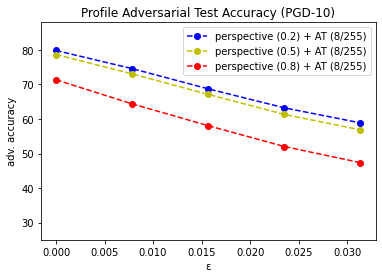

In [24]:
#plt.plot(x, y,'--mo', label='AT (8/255)')
plt.plot(x, y,'--bo', label='perspective (0.2) + AT (8/255)')
plt.plot(x, y2,'--yo', label='perspective (0.5) + AT (8/255)')
plt.plot(x, y3,'--ro', label='perspective (0.8) + AT (8/255)')
plt.title("Profile Adversarial Test Accuracy (PGD-10)")
plt.xlabel("\u03B5")
plt.ylim([25,88])
plt.ylabel("adv. accuracy")
plt.legend()
plt.show()